<a href="https://colab.research.google.com/github/VVKate/Neural_University_HomeWorks/blob/main/6_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнеее задание: Июльский курс (2020). Pro. Занятие 6
# Нейронные сети для решения задачи регрессии
## Верхошинская Катерина Викторовна



## **LIGHT**



**Задание** 

Используя шаблон ноутбука, требуется:
1. Загрузить xTrain на числовых данных
2. Загрузить xTrainС из "Примечаний" (тексты)
3. Создать словарь
4. Превратить xTrainC в формат bag of words (2000 самых популярных слов)
5. Сделать нормирование данных
6. Написать нейронную сеть


In [ ]:
import numpy as np 
import pandas as pd 

from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error 


import random 
import math 
import re 
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
#Загружаем данные в data frame и смотрим на его размер
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/moscow.csv', sep=";") 
print(df.shape)

(252536, 14)


In [ ]:
#Посмотрим на "шапку" таблицы
df.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
3,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."


In [ ]:
#Вытаскиваем данные в numpy array, убирая нечётные строки (пустые строки "Для заметок"),
df = df.iloc[::2,:] 
data = df.values

In [ ]:
#Вычисляем количество комнат

#maxRoomCount - максимальное число комнат в квартире
#d - описание квартиры, одна строка из data1
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] 
  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) 
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount 
  except: 
    if (roomsCountStr == roomsCountStr): 
      if ("Ст" in roomsCountStr): 
        roomsCount = maxRoomCount + 1

  return roomsCount

In [ ]:
#Делаем маску однокомнатных квартир
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] 
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
#Показываем пример данных (первые 5 колонок)
print(df.iloc[:,:5].head(20))

   Комнат        Метро / ЖД станции От станции        Дом Балкон
0       1               Шелепиха м.        12п    35/37 М    NaN
2       1        Пятницкое шоссе м.        30т    11/14 П      Л
4       1              Планерная м.         5т    11/22 П      Б
6       1            Шаболовская м.        12п     8/12 ?      Б
8       1           Бабушкинская м.        15п     4/14 П    NaN
10      1               Шелепиха м.        15п     9/36 К    NaN
12      1    Улица Дмитриевского м.         2п     7/16 П      Л
14      1  Бульвар Рокоссовского м.         2п      2/5 К      Б
16      1           Марьина Роща м.        10п     7/14 П     2Б
18      1                Марьино м.        20п  10/24 М-К    NaN
20      1                Марьино м.         5т      5/5 П      Б
22      1              Печатники м.         5т     2/12 П      -
24      1      Красногвардейская м.         3п    20/30 М      Б
26      1      Красногвардейская м.         3п    12/30 М      Б
28      1      Красногвар

In [ ]:
print(df.columns)

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


### Функции - парсеры данных

In [ ]:
#Превращаем число комнат в категорию

# 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
def getRoomsCountCategory(d, maxRoomCount):
  
  #Получаем число комнат
  roomsCount = getRoomsCount(d, maxRoomCount) 
  
  #Превращаем в категорию
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount + 2) 
  
  return roomsCount

In [ ]:
#Получаем индекс станции метро

#allMetroNames - все уникальные названия метро в базе
#0 зарезервирован на неопознанное метро
def getMetro(d, allMetroNames):
  
  #Получаем строку метро
  metroStr = d[1] 
  metro = 0
  
  #Если находим метро во всех названиях, присваиваем индекс
  if (metroStr in allMetroNames): 
    metro = allMetroNames.index(metroStr) + 1
      
  return metro

In [ ]:
#Получаем тип метро

#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):

  #Получаем строку метро
  metroTypeStr = d[1]

  #Число классов метро
  metroTypeClasses = 5

  #Изначально считаем последний класс
  metroType = metroTypeClasses - 1 
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольца
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


In [ ]:
#Вычисляем растояние до метро

def getMetroDistance(d):
  #Получаем строку
  metroDistanceStr = d[2] 
  
  #Расстояние до метро
  metroDistance = 0 

  #Тип расстояния - пешком или на транспорте
  metroDistanceType = 0 
  
  #Еcли строка не равна nan, 
  #Определяем тип расстояния - Пешком(1) или на транспорте(2)   
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #Дополнительно обработаем "на транспорте" и "неопознанный"
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance


In [ ]:
#Получаем 4 типа данных
#1 - этаж квартиры
#2 - этажность дома
#3 - индикатор, что последний этаж
#4 - тип дома

def getHouseTypeAndFloor(d):
  try:
    #Получаем строку типа дома и этажей
    houseStr = d[3] 
  except:
    houseStr = ""
  
  #Тип дома
  houseType = 0

  #Этаж квартиры
  floor = 0 

  #Этажность дома
  floors = 0 

  #Индикатор последнего этажа
  isLastFloor = 0 
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки: этажа, этажности, типа дома
      floorStr = houseStr[:slashIndex]
      floorsStr = houseStr[slashIndex+1:spaceIndex] 
      houseTypeStr = houseStr[spaceIndex+1:]

      #Выбираем категорию этажа
      #Первый этаж выделяем в отдельную категорию
      #Если этаж последний, включаем индикатор последнего этажа
      #Если строка не парсится в число, то категория этажа = 0 (отдельная)
      try:
        #Превращаем строку в число
        floor = int(floorStr) 
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1):
          floor = 1 
        if (floor == floors): 
          isLastFloor = 1 
      except:
        floor = 0 

      #Выбираем категорию этажности дома
      try:
        #Превращаем строку в число
        #Если строка не парсится в число, то категория этажности = 0 (отдельная)
        floors = int(floorsStr) 
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


In [ ]:
#Вычисляем тип балкона
def getBalcony(d):
  
  #Полуаем строку
  balconyStr = d[4] 
  
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  
  #Проверяем на nan
  if (balconyStr == balconyStr):
     balcony = (balconyVariants.index(balconyStr) + 1)
  else: balcony = 0 
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

In [ ]:
#Определяем тип санузла

def getWC(d):
  
  #Получаем строку
  wcStr = d[5] 

  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  
  #Проверяем на nan
  if (wcStr == wcStr):  wc = wcVariants.index(wcStr) + 1
  else: wc = 0 

  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

In [ ]:
#Определяем площадь

def getArea(d):
  areaStr = d[6] #Поулачем строку площади
  
  #Находим разделитель "/", берём число до разделителя и превращаем в число,
  #Если не получается или нет разделителя, возвращаем 0
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") 
    try:
      area = float(areaStr[:slashIndex]) 
    except:
      area = 0 
  else:
    area = 0 
    
  return area

In [ ]:
#Полуаем цену

#Загружаем строку
#Пробуем превратить в число
#Если не получается, возвращаем 0
def getCost(d):
  costStr = d[7] 
  try:
    cost = float(costStr) 
  except:
    cost = 0 
  
  return cost

In [ ]:
#Получаем комментарий

def getComment(d):
  commentStr = d[-1]
  
  return commentStr

In [ ]:
#Объединяем все числовые параметры вместе

def getAllParameters(d, allMetroNames):
  
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#### Генераторы xTrain и yTrain

In [ ]:
#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Записываем данные в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

In [ ]:
#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Загружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

### Функции работы с текстовыми данными

In [ ]:
# Очистка текста и превращение в набор слов

def text2Words(text):

  #Удаляем лишние символы и переводим в нижний регистр
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() 
  
  
  words = [] 
  currWord = ""
  
  #идём по всем символам, игнорируем системынй символ
  for symbol in text:
    
    if (symbol != "\ufeff"): 
      if (symbol != " "): 
        currWord += symbol 
      else: 
        if (currWord != ""): 
          words.append(currWord) 
          currWord = "" 

  #Добавляем финальное слово, если оно не пустое
  if (currWord != ""):
        words.append(currWord)
  
  return words

In [ ]:
# Создание словаря - все слова, упорядоченные по частоте появления

def createVocabulary(allWords):
  
  #Создаём словарь, 
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 

  #Выцепляем лист из словаря
  #И сортируем по частоте появления
  wordsList = list(wCount.items())
  wordsList.sort(key = lambda i:i[1], reverse=1)

  sortedWords = [] 

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0])

  wordIndexes = dict.fromkeys(allWords, 0)
  
  #Проходим по всем словам и ставим индекс = индексу слова в отсортированном листе слов + 1
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1
  return wordIndexes

In [ ]:
# Преобразования листа слов в лист индексов

def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словам, проверяем есть ли слово в словаре  
  #Если слово есть в словаре, то индекс = индексу слова в словаре
  #Если индекс ниже maxWordsCount - черты отсечения слов, то записываем индекс
  #Иначе останется значение 0

  for word in words:
    wordIndex = 0 
    wordInVocabulary = word in vocabulary 

    if (wordInVocabulary):
      index = vocabulary[word] 
      if (index < maxWordsCount): 
        wordIndex = index
      
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes

In [ ]:
# Преобразование по принципу words bag

def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 
    
  return out

In [ ]:
# Преобразование выборки (обучающей или проверочной) по принципу words bag

def changeSetTo01(trainSet, wordsCount):
  out = []

  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
  return np.array(out)

In [ ]:
# Формируем обучающую выборку из примечаний к квартирам в виде слов

def getXTrainComments(data):
  xTrainComments = [] # Обучающся выборка
  allTextComments = "" # Все тексты 
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария"  #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText)  #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

In [ ]:
# Формируем обучающую выборку из примечаний к квартирам в виде индексов

def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] # Итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

In [ ]:
# Формируем обучающую выборку из примечаний к квартирам в виде индексов
# С приведением к стандартной длине всех векторов - cropLen

def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] # Итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

### Формируем выборки 
* xTrain и yTrain

* Собираем xTrainС по текстам("Примечания"), преобразеум xTrainC в bag of words, оставив 2000 самых популярных слов




In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)
print(xTrain.shape)

(62504, 109)


In [ ]:
xTrainC, allTextComments = getXTrainComments(data1) 
allWords = text2Words(allTextComments)
allWords = allWords[::10]  #Берём 10% слов (иначе словарь слишком долго формируется)
vocabulary = createVocabulary(allWords) #Создаём словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) 

#Выводим результаты, чтобы проверить, что все правильно собралось
print(xTrain.shape)
print(xTrainC.shape)
print(xTrainC01.shape)

(62504, 109)
(62504,)
(62504, 2000)


### Нормирование данных



In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Создаём нормировщик нормальным распределением
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
# Смотрим на минимальные и максимальные значения
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


In [ ]:
# Формируем проверочную выборку

splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

### Пишем нейронную сеть



In [ ]:
#Функция проверки результатов для испозования её в колбэках
def on_epoch_end(epoch, logs):
  #Полуаем выход сети на проверочно выборке
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) 

  #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  predUnscaled = yScaler.inverse_transform(pred).flatten() 
  
  #Делаем такое же обратное нормирование yTrain к базовым ценам
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() 
  
  #Считаем разность предсказания и правильных цен
  delta = predUnscaled - yTrainUnscaled 
  
  #Берём модуль отклонения
  absDelta = abs(delta) 
  
  #Выводим усреднённую ошибку в миллионах рублей
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) 

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

Эпоха 0 модуль ошибки 1.651
Эпоха 1 модуль ошибки 1.624
Эпоха 2 модуль ошибки 1.264
Эпоха 3 модуль ошибки 1.169
Эпоха 4 модуль ошибки 1.164
Эпоха 5 модуль ошибки 1.306
Эпоха 6 модуль ошибки 1.137
Эпоха 7 модуль ошибки 1.08
Эпоха 8 модуль ошибки 1.205
Эпоха 9 модуль ошибки 1.18
Эпоха 10 модуль ошибки 1.08
Эпоха 11 модуль ошибки 1.007
Эпоха 12 модуль ошибки 0.912
Эпоха 13 модуль ошибки 0.958
Эпоха 14 модуль ошибки 1.026
Эпоха 15 модуль ошибки 0.932
Эпоха 16 модуль ошибки 0.938
Эпоха 17 модуль ошибки 0.872
Эпоха 18 модуль ошибки 0.907
Эпоха 19 модуль ошибки 0.917
Эпоха 20 модуль ошибки 0.875
Эпоха 21 модуль ошибки 0.903
Эпоха 22 модуль ошибки 0.894
Эпоха 23 модуль ошибки 0.907
Эпоха 24 модуль ошибки 1.018
Эпоха 25 модуль ошибки 0.969
Эпоха 26 модуль ошибки 0.89
Эпоха 27 модуль ошибки 0.922
Эпоха 28 модуль ошибки 1.225
Эпоха 29 модуль ошибки 0.858
Модуль ошибки 0.8579611114560942


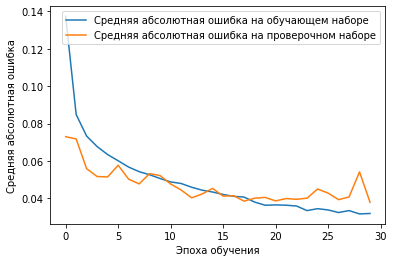

In [ ]:
#Создаем сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(100, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

#Компилируем
model.compile(optimizer=Adam(lr=1e-3), loss='MAE')

#Обучаем
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=30, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])


#Проверяем результаты

#Полуаем выход сети на проверочной выборке
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])

#Делаем обратное нормирование выхода к изначальным величинам цен квартир
predUnscaled = yScaler.inverse_transform(pred).flatten() 

#Делаем такое же обратное нормирование yTrain к базовым ценам
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() 

#Считаем разность предсказания и правильных цен
delta = predUnscaled - yTrainUnscaled 

#Берём модуль отклонения
absDelta = abs(delta) 

#Выводим усреднённую ошибку в миллионах рублей
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta))) 

#Визуализируем результаты, выводим графики ошибки
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

**Итог:** модуль ошибки составил 0.858, тоесть 858 тысяч рублей

## **PRO**

**Вариант 2**

**Задание:**
На базе квартир добейтесь средней абсолютной ошибки не более 800 тысяч

In [ ]:
import numpy as np 
import pandas as pd 

from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error 


import random 
import math 
import re 
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
#Загружаем данные в data frame и смотрим на его размер
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/moscow.csv', sep=";") 
print(df.shape)

(252536, 14)


In [ ]:
#Посмотрим на "шапку" таблицы
df.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
3,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."


In [ ]:
#Вытаскиваем данные в numpy array, убирая нечётные строки (пустые строки "Для заметок"),
df = df.iloc[::2,:] 
data = df.values

In [ ]:
#Вычисляем количество комнат

#maxRoomCount - максимальное число комнат в квартире
#d - описание квартиры, одна строка из data1
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] 
  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) 
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount 
  except: 
    if (roomsCountStr == roomsCountStr): 
      if ("Ст" in roomsCountStr): 
        roomsCount = maxRoomCount + 1

  return roomsCount

In [ ]:
#Делаем маску однокомнатных квартир
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] 
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
#Показываем пример данных (первые 5 колонок)
print(df.iloc[:,:5].head(20))

   Комнат        Метро / ЖД станции От станции        Дом Балкон
0       1               Шелепиха м.        12п    35/37 М    NaN
2       1        Пятницкое шоссе м.        30т    11/14 П      Л
4       1              Планерная м.         5т    11/22 П      Б
6       1            Шаболовская м.        12п     8/12 ?      Б
8       1           Бабушкинская м.        15п     4/14 П    NaN
10      1               Шелепиха м.        15п     9/36 К    NaN
12      1    Улица Дмитриевского м.         2п     7/16 П      Л
14      1  Бульвар Рокоссовского м.         2п      2/5 К      Б
16      1           Марьина Роща м.        10п     7/14 П     2Б
18      1                Марьино м.        20п  10/24 М-К    NaN
20      1                Марьино м.         5т      5/5 П      Б
22      1              Печатники м.         5т     2/12 П      -
24      1      Красногвардейская м.         3п    20/30 М      Б
26      1      Красногвардейская м.         3п    12/30 М      Б
28      1      Красногвар

In [ ]:
print(df.columns)

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


### Функции - парсеры данных

In [ ]:
#Превращаем число комнат в категорию

# 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
def getRoomsCountCategory(d, maxRoomCount):
  
  #Получаем число комнат
  roomsCount = getRoomsCount(d, maxRoomCount) 
  
  #Превращаем в категорию
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount + 2) 
  
  return roomsCount

In [ ]:
#Получаем индекс станции метро

#allMetroNames - все уникальные названия метро в базе
#0 зарезервирован на неопознанное метро
def getMetro(d, allMetroNames):
  
  #Получаем строку метро
  metroStr = d[1] 
  metro = 0
  
  #Если находим метро во всех названиях, присваиваем индекс
  if (metroStr in allMetroNames): 
    metro = allMetroNames.index(metroStr) + 1
      
  return metro

In [ ]:
#Получаем тип метро

#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):

  #Получаем строку метро
  metroTypeStr = d[1]

  #Число классов метро
  metroTypeClasses = 5

  #Изначально считаем последний класс
  metroType = metroTypeClasses - 1 
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольца
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


In [ ]:
#Вычисляем растояние до метро

def getMetroDistance(d):
  #Получаем строку
  metroDistanceStr = d[2] 
  
  #Расстояние до метро
  metroDistance = 0 

  #Тип расстояния - пешком или на транспорте
  metroDistanceType = 0 
  
  #Еcли строка не равна nan, 
  #Определяем тип расстояния - Пешком(1) или на транспорте(2)   
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #Дополнительно обработаем "на транспорте" и "неопознанный"
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance


In [ ]:
#Получаем 4 типа данных
#1 - этаж квартиры
#2 - этажность дома
#3 - индикатор, что последний этаж
#4 - тип дома

def getHouseTypeAndFloor(d):
  try:
    #Получаем строку типа дома и этажей
    houseStr = d[3] 
  except:
    houseStr = ""
  
  #Тип дома
  houseType = 0

  #Этаж квартиры
  floor = 0 

  #Этажность дома
  floors = 0 

  #Индикатор последнего этажа
  isLastFloor = 0 
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки: этажа, этажности, типа дома
      floorStr = houseStr[:slashIndex]
      floorsStr = houseStr[slashIndex+1:spaceIndex] 
      houseTypeStr = houseStr[spaceIndex+1:]

      #Выбираем категорию этажа
      #Первый этаж выделяем в отдельную категорию
      #Если этаж последний, включаем индикатор последнего этажа
      #Если строка не парсится в число, то категория этажа = 0 (отдельная)
      try:
        #Превращаем строку в число
        floor = int(floorStr) 
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1):
          floor = 1 
        if (floor == floors): 
          isLastFloor = 1 
      except:
        floor = 0 

      #Выбираем категорию этажности дома
      try:
        #Превращаем строку в число
        #Если строка не парсится в число, то категория этажности = 0 (отдельная)
        floors = int(floorsStr) 
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


In [ ]:
#Вычисляем тип балкона
def getBalcony(d):
  
  #Полуаем строку
  balconyStr = d[4] 
  
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  
  #Проверяем на nan
  if (balconyStr == balconyStr):
     balcony = (balconyVariants.index(balconyStr) + 1)
  else: balcony = 0 
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

In [ ]:
#Определяем тип санузла

def getWC(d):
  
  #Получаем строку
  wcStr = d[5] 

  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  
  #Проверяем на nan
  if (wcStr == wcStr):  wc = wcVariants.index(wcStr) + 1
  else: wc = 0 

  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

In [ ]:
#Определяем площадь

def getArea(d):
  areaStr = d[6] #Поулачем строку площади
  
  #Находим разделитель "/", берём число до разделителя и превращаем в число,
  #Если не получается или нет разделителя, возвращаем 0
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") 
    try:
      area = float(areaStr[:slashIndex]) 
    except:
      area = 0 
  else:
    area = 0 
    
  return area

In [ ]:
#Полуаем цену

#Загружаем строку
#Пробуем превратить в число
#Если не получается, возвращаем 0
def getCost(d):
  costStr = d[7] 
  try:
    cost = float(costStr) 
  except:
    cost = 0 
  
  return cost

In [ ]:
#Получаем комментарий

def getComment(d):
  commentStr = d[-1]
  
  return commentStr

In [ ]:
#Объединяем все числовые параметры вместе

def getAllParameters(d, allMetroNames):
  
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#### Генераторы xTrain и yTrain

In [ ]:
#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Записываем данные в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

In [ ]:
#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Загружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

### Функции работы с текстовыми данными

In [ ]:
# Очистка текста и превращение в набор слов

def text2Words(text):

  #Удаляем лишние символы и переводим в нижний регистр
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() 
  
  
  words = [] 
  currWord = ""
  
  #идём по всем символам, игнорируем системынй символ
  for symbol in text:
    
    if (symbol != "\ufeff"): 
      if (symbol != " "): 
        currWord += symbol 
      else: 
        if (currWord != ""): 
          words.append(currWord) 
          currWord = "" 

  #Добавляем финальное слово, если оно не пустое
  if (currWord != ""):
        words.append(currWord)
  
  return words

In [ ]:
# Создание словаря - все слова, упорядоченные по частоте появления

def createVocabulary(allWords):
  
  #Создаём словарь, 
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 

  #Выцепляем лист из словаря
  #И сортируем по частоте появления
  wordsList = list(wCount.items())
  wordsList.sort(key = lambda i:i[1], reverse=1)

  sortedWords = [] 

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0])

  wordIndexes = dict.fromkeys(allWords, 0)
  
  #Проходим по всем словам и ставим индекс = индексу слова в отсортированном листе слов + 1
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1
  return wordIndexes

In [ ]:
# Преобразования листа слов в лист индексов

def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словам, проверяем есть ли слово в словаре  
  #Если слово есть в словаре, то индекс = индексу слова в словаре
  #Если индекс ниже maxWordsCount - черты отсечения слов, то записываем индекс
  #Иначе останется значение 0

  for word in words:
    wordIndex = 0 
    wordInVocabulary = word in vocabulary 

    if (wordInVocabulary):
      index = vocabulary[word] 
      if (index < maxWordsCount): 
        wordIndex = index
      
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes

In [ ]:
# Преобразование по принципу words bag

def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 
    
  return out

In [ ]:
# Преобразование выборки (обучающей или проверочной) по принципу words bag

def changeSetTo01(trainSet, wordsCount):
  out = []

  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
  return np.array(out)

In [ ]:
# Формируем обучающую выборку из примечаний к квартирам в виде слов

def getXTrainComments(data):
  xTrainComments = [] # Обучающся выборка
  allTextComments = "" # Все тексты 
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария"  #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText)  #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

In [ ]:
# Формируем обучающую выборку из примечаний к квартирам в виде индексов

def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] # Итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

In [ ]:
# Формируем обучающую выборку из примечаний к квартирам в виде индексов
# С приведением к стандартной длине всех векторов - cropLen

def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] # Итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

### Формируем выборки 
* xTrain и yTrain

* Собираем xTrainС по текстам("Примечания"), преобразеум xTrainC в bag of words, оставив 2000 самых популярных слов




In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)
print(xTrain.shape)

(62504, 109)


In [ ]:
xTrainC, allTextComments = getXTrainComments(data1) 
allWords = text2Words(allTextComments)
allWords = allWords[::10]  #Берём 10% слов (иначе словарь слишком долго формируется)
vocabulary = createVocabulary(allWords) #Создаём словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) 

#Выводим результаты, чтобы проверить, что все правильно собралось
print(xTrain.shape)
print(xTrainC.shape)
print(xTrainC01.shape)

(62504, 109)
(62504,)
(62504, 2000)


### Нормирование данных



In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Создаём нормировщик нормальным распределением
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
# Смотрим на минимальные и максимальные значения
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


In [ ]:
# Формируем проверочную выборку

splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

### Пишем нейронную сеть



In [ ]:
#Функция проверки результатов для испозования её в колбэках
def on_epoch_end(epoch, logs):
  #Полуаем выход сети на проверочно выборке
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) 

  #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  predUnscaled = yScaler.inverse_transform(pred).flatten() 
  
  #Делаем такое же обратное нормирование yTrain к базовым ценам
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() 
  
  #Считаем разность предсказания и правильных цен
  delta = predUnscaled - yTrainUnscaled 
  
  #Берём модуль отклонения
  absDelta = abs(delta) 
  
  #Выводим усреднённую ошибку в миллионах рублей
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) 

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

Эпоха 0 модуль ошибки 1.387
Эпоха 1 модуль ошибки 1.161
Эпоха 2 модуль ошибки 1.144
Эпоха 3 модуль ошибки 1.159
Эпоха 4 модуль ошибки 1.054
Эпоха 5 модуль ошибки 0.996
Эпоха 6 модуль ошибки 1.004
Эпоха 7 модуль ошибки 0.89
Эпоха 8 модуль ошибки 0.879
Эпоха 9 модуль ошибки 0.871
Эпоха 10 модуль ошибки 0.921
Эпоха 11 модуль ошибки 0.837
Эпоха 12 модуль ошибки 0.845
Эпоха 13 модуль ошибки 0.821
Эпоха 14 модуль ошибки 0.817
Эпоха 15 модуль ошибки 0.839
Эпоха 16 модуль ошибки 0.784
Эпоха 17 модуль ошибки 0.781
Эпоха 18 модуль ошибки 0.789
Эпоха 19 модуль ошибки 0.792
Эпоха 20 модуль ошибки 0.77
Эпоха 21 модуль ошибки 1.175
Эпоха 22 модуль ошибки 0.761
Эпоха 23 модуль ошибки 0.779
Эпоха 24 модуль ошибки 0.767
Эпоха 25 модуль ошибки 0.81
Эпоха 26 модуль ошибки 0.759
Эпоха 27 модуль ошибки 0.741
Эпоха 28 модуль ошибки 0.749
Эпоха 29 модуль ошибки 0.797
Эпоха 30 модуль ошибки 0.762
Эпоха 31 модуль ошибки 0.71
Эпоха 32 модуль ошибки 0.805
Эпоха 33 модуль ошибки 0.725
Эпоха 34 модуль ошибки 0.717

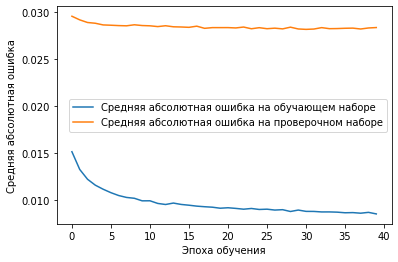

In [ ]:
#Создаем сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

#Компилируем
model.compile(optimizer=Adam(lr=1e-3), loss='MAE')

#Обучаем
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])


#Дообучаем сеть меняя шаг оптимизатора
print()
print('Меняем шаг обучения на 1e-4')
model.compile(optimizer=Adam(lr=1e-4), loss='MAE')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])


#Проверяем результаты

#Полуаем выход сети на проверочной выборке
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])

#Делаем обратное нормирование выхода к изначальным величинам цен квартир
predUnscaled = yScaler.inverse_transform(pred).flatten() 

#Делаем такое же обратное нормирование yTrain к базовым ценам
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() 

#Считаем разность предсказания и правильных цен
delta = predUnscaled - yTrainUnscaled 

#Берём модуль отклонения
absDelta = abs(delta) 

#Выводим усреднённую ошибку в миллионах рублей
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta))) 

#Визуализируем результаты, выводим графики ошибки
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

**Итоги:**

Итоговый модуль ошибки = **0.641**


Тоесть ошибка составила **641 тысячу рублей**, что удовлетворяет условие задачи (не более 800 тысяч)



## **ULTRA PRO**

**Задание:** Найдите любую базу, подходящую для регрессии:
1. Спарсите данные
2. Разделите данные на обучающую и проверочную выборки
3. Напишите сеть для регрессии
4. Сделайте визуализацию результата
5. Напишите ваши результаты и выводы

In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop 
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from IPython.display import clear_output


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


В качестве базы для решения задачи, была найдена и скачена в интернете база машин autos.csv, хорошо подходящая для задачи регрессии. База - таблица из дат, цифровых и текстовых полей на немецком языке. Задача - определить по данным машины её стоимость. 

In [ ]:
cars = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/autos.csv', sep=',')

In [ ]:
cars.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21
1,2016-04-07 10:06:22,Volkswagen_Passat_Variant_2.0_TDI_Comfortline,privat,Angebot,2799,control,kombi,2005,manuell,140,passat,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,0.0,57290.0,2016-04-07 10:25:17
2,2016-03-27 11:38:00,BMW_530i_T�V_7/17_Scheckheftgepflegt_sehr_gute...,privat,Angebot,3699,test,limousine,2002,automatik,231,5er,150000,7,benzin,bmw,nein,2016-03-27 00:00:00,0.0,68309.0,2016-04-07 06:44:26
3,2016-03-23 14:52:51,Opel_Meriva_1.Hand_T�V_3.2018,privat,Angebot,2900,test,NaN,2018,manuell,90,meriva,150000,5,benzin,opel,nein,2016-03-23 00:00:00,0.0,49716.0,2016-03-31 01:16:33 ...
4,2016-03-10 19:38:18,Citroen_C4_Grand_Picasso.,privat,Angebot,5555,control,NaN,2017,manuell,125,c4,125000,4,NaN,citroen,nein,2016-03-10 00:00:00,0.0,31139.0,2016-03-16 09:16:46 ...


In [ ]:
#удаляем ненужные столбцы, мало влияющие на обучение
del cars['name']
del cars['dateCrawled']
del cars['dateCreated']

In [ ]:
cars.head()

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,nrOfPictures,postalCode,lastSeen
0,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,0.0,60437.0,2016-04-06 10:17:21
1,privat,Angebot,2799,control,kombi,2005,manuell,140,passat,150000,12,diesel,volkswagen,ja,0.0,57290.0,2016-04-07 10:25:17
2,privat,Angebot,3699,test,limousine,2002,automatik,231,5er,150000,7,benzin,bmw,nein,0.0,68309.0,2016-04-07 06:44:26
5,privat,Angebot,3300,test,limousine,1995,automatik,113,e_klasse,150000,1,diesel,mercedes_benz,nein,0.0,53879.0,2016-04-05 15:16:05
6,privat,Angebot,3500,control,limousine,2004,automatik,122,e_klasse,150000,11,diesel,mercedes_benz,nein,0.0,67071.0,2016-03-30 15:46


In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89318 entries, 0 to 89317
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dateCrawled          89318 non-null  object 
 1   seller               89318 non-null  object 
 2   offerType            89318 non-null  object 
 3   price                89318 non-null  int64  
 4   abtest               89318 non-null  object 
 5   vehicleType          82773 non-null  object 
 6   yearOfRegistration   89318 non-null  int64  
 7   gearbox              85563 non-null  object 
 8   powerPS              89318 non-null  int64  
 9   model                85876 non-null  object 
 10  kilometer            89318 non-null  int64  
 11  monthOfRegistration  89318 non-null  int64  
 12  fuelType             83952 non-null  object 
 13  brand                89318 non-null  object 
 14  notRepairedDamage    75474 non-null  object 
 15  dateCreated          89318 non-null 

Как видно из статистики, в данном датасете довольно много пропусков, избавимся от них

In [ ]:
cars = cars.dropna(axis='index', how='any', subset=['seller'])
cars = cars.dropna(axis='index', how='any', subset=['price'])
cars = cars.dropna(axis='index', how='any', subset=['abtest'])
cars = cars.dropna(axis='index', how='any', subset=['vehicleType'])
cars = cars.dropna(axis='index', how='any', subset=['yearOfRegistration'])
cars = cars.dropna(axis='index', how='any', subset=['gearbox'])
cars = cars.dropna(axis='index', how='any', subset=['powerPS'])
cars = cars.dropna(axis='index', how='any', subset=['model'])
cars = cars.dropna(axis='index', how='any', subset=['kilometer'])
cars = cars.dropna(axis='index', how='any', subset=['monthOfRegistration'])
cars = cars.dropna(axis='index', how='any', subset=['fuelType'])
cars = cars.dropna(axis='index', how='any', subset=['brand'])
cars = cars.dropna(axis='index', how='any', subset=['postalCode'])

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75626 entries, 0 to 89317
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   seller               75626 non-null  object 
 1   offerType            75626 non-null  object 
 2   price                75626 non-null  int64  
 3   abtest               75626 non-null  object 
 4   vehicleType          75626 non-null  object 
 5   yearOfRegistration   75626 non-null  int64  
 6   gearbox              75626 non-null  object 
 7   powerPS              75626 non-null  int64  
 8   model                75626 non-null  object 
 9   kilometer            75626 non-null  int64  
 10  monthOfRegistration  75626 non-null  int64  
 11  fuelType             75626 non-null  object 
 12  brand                75626 non-null  object 
 13  notRepairedDamage    67199 non-null  object 
 14  nrOfPictures         75626 non-null  float64
 15  postalCode           75626 non-null 

Пропуки убраны, со столбцом lastSeen далее мы работать не будем, поэтому пропуски в нем нас не волнуют. 

Посмотрим на графики зависимасти цены от других параметров:

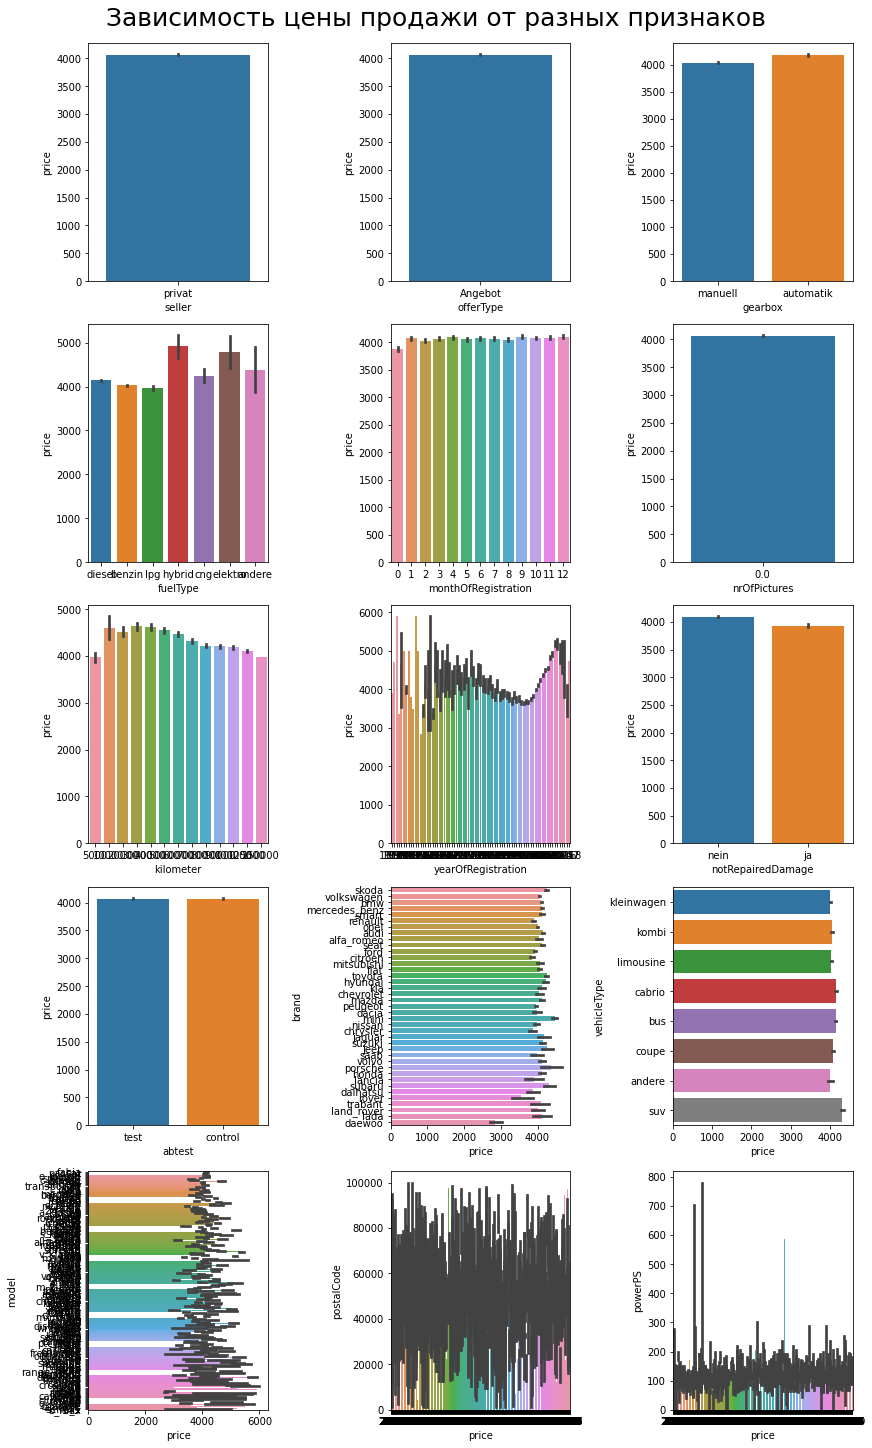

In [ ]:
fig, ax = plt.subplots(5, 3, sharex=False, sharey=False, figsize=(12, 20), constrained_layout=True)
fig.suptitle('Зависимость цены продажи от разных признаков', fontsize=25)
sns.barplot(x="seller", y="price", data=cars, ax=ax[0, 0])
sns.barplot(x="offerType", y="price", data=cars, ax=ax[0, 1])
sns.barplot(x="gearbox", y="price", data=cars, ax=ax[0, 2])
sns.barplot(x="fuelType", y="price", data=cars, ax=ax[1, 0])
sns.barplot(x="monthOfRegistration", y="price", data=cars, ax=ax[1, 1])
sns.barplot(x="nrOfPictures", y="price", data=cars, ax=ax[1, 2])
sns.barplot(x="kilometer", y="price", data=cars, ax=ax[2, 0])
sns.barplot(x="yearOfRegistration", y="price", data=cars, ax=ax[2, 1])
sns.barplot(x="notRepairedDamage", y="price", data=cars, ax=ax[2, 2])
sns.barplot(x="abtest", y="price", data=cars, ax=ax[3, 0])
sns.barplot(x="price", y="brand", data=cars, ax=ax[3, 1]) 
sns.barplot(x="price", y="vehicleType", data=cars, ax=ax[3, 2])
sns.barplot(x="price", y="model", data=cars, ax=ax[4, 0])
sns.barplot(x="price", y="postalCode", data=cars, ax=ax[4, 1])
sns.barplot(x="price", y="powerPS", data=cars, ax=ax[4, 2])

Корректируем выбрасы:

In [ ]:
cars = cars.loc[cars['price'] != 0 ]
cars = cars.loc[cars['powerPS'] < 250 ]
cars = cars.loc[cars['brand'] != 'porsche']

Посмотрим на графики после коррекции:

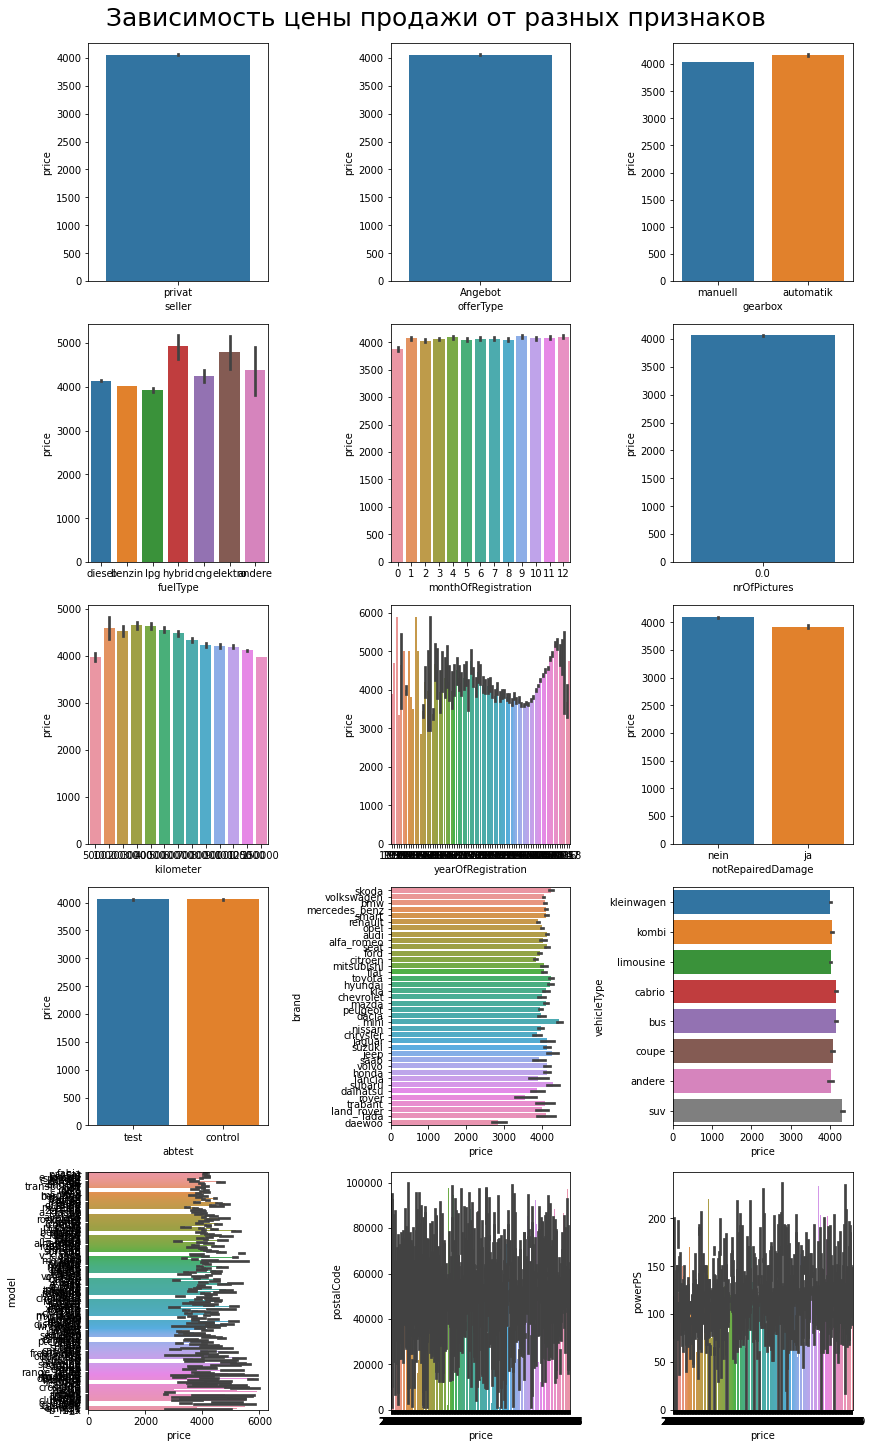

In [ ]:
fig, ax = plt.subplots(5, 3, sharex=False, sharey=False, figsize=(12, 20), constrained_layout=True)
fig.suptitle('Зависимость цены продажи от разных признаков', fontsize=25)
sns.barplot(x="seller", y="price", data=cars, ax=ax[0, 0])
sns.barplot(x="offerType", y="price", data=cars, ax=ax[0, 1])
sns.barplot(x="gearbox", y="price", data=cars, ax=ax[0, 2])
sns.barplot(x="fuelType", y="price", data=cars, ax=ax[1, 0])
sns.barplot(x="monthOfRegistration", y="price", data=cars, ax=ax[1, 1])
sns.barplot(x="nrOfPictures", y="price", data=cars, ax=ax[1, 2])
sns.barplot(x="kilometer", y="price", data=cars, ax=ax[2, 0])
sns.barplot(x="yearOfRegistration", y="price", data=cars, ax=ax[2, 1])
sns.barplot(x="notRepairedDamage", y="price", data=cars, ax=ax[2, 2])
sns.barplot(x="abtest", y="price", data=cars, ax=ax[3, 0])
sns.barplot(x="price", y="brand", data=cars, ax=ax[3, 1]) 
sns.barplot(x="price", y="vehicleType", data=cars, ax=ax[3, 2])
sns.barplot(x="price", y="model", data=cars, ax=ax[4, 0])
sns.barplot(x="price", y="postalCode", data=cars, ax=ax[4, 1])
sns.barplot(x="price", y="powerPS", data=cars, ax=ax[4, 2])

In [ ]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          
  for _id, name in enumerate(s):    
    ret.update({name: _id})         
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [ ]:
cars.columns

Index(['seller', 'offerType', 'price', 'abtest', 'vehicleType',
       'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer',
       'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage',
       'nrOfPictures', 'postalCode', 'lastSeen '],
      dtype='object')

Из построенных графиков, выберем самые значащие дааные и обратоем их для дальнейсей отправки в нейронную сеть. Такие параметры как seller, offerType, nrOfPictures брать в расчет нет смысла, так как там всего одно значение. 



In [ ]:
# Создаём словари по всем текстовым колонкам
abtest_dict = create_dict(set(cars['abtest']))
gearbox_dict = create_dict(set(cars['gearbox']))
model_dict = create_dict(set(cars['model']))
vehicleType_dict = create_dict(set(cars['vehicleType']))
fuelType_dict = create_dict(set(cars['fuelType']))
brand_dict = create_dict(set(cars['brand']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
powerPS = preprocessing.scale(cars['powerPS'])
kilometer = preprocessing.scale(cars['kilometer'])
monthOfRegistration = preprocessing.scale(cars['monthOfRegistration'])
postalCode = preprocessing.scale(cars['postalCode']) 

In [ ]:
print(vehicleType_dict)
print()
print(fuelType_dict)
print()
print(brand_dict)

{'limousine': 0, 'suv': 1, 'cabrio': 2, 'kleinwagen': 3, 'kombi': 4, 'coupe': 5, 'andere': 6, 'bus': 7}

{'benzin': 0, 'elektro': 1, 'diesel': 2, 'andere': 3, 'hybrid': 4, 'cng': 5, 'lpg': 6}

{'honda': 0, 'volkswagen': 1, 'fiat': 2, 'toyota': 3, 'hyundai': 4, 'trabant': 5, 'citroen': 6, 'lancia': 7, 'kia': 8, 'renault': 9, 'mitsubishi': 10, 'nissan': 11, 'jaguar': 12, 'chrysler': 13, 'audi': 14, 'dacia': 15, 'chevrolet': 16, 'mazda': 17, 'jeep': 18, 'rover': 19, 'daihatsu': 20, 'skoda': 21, 'daewoo': 22, 'volvo': 23, 'smart': 24, 'mini': 25, 'subaru': 26, 'mercedes_benz': 27, 'suzuki': 28, 'alfa_romeo': 29, 'lada': 30, 'peugeot': 31, 'land_rover': 32, 'ford': 33, 'saab': 34, 'bmw': 35, 'seat': 36, 'opel': 37}


In [ ]:
print(abtest_dict)
print()
print(gearbox_dict)
print()
print(model_dict)

{'control': 0, 'test': 1}

{'automatik': 0, 'manuell': 1}

{'601': 0, 'niva': 1, 'discovery': 2, 'sprinter': 3, '100': 4, 'touran': 5, 'b_klasse': 6, 'rav': 7, 'golf': 8, 'kaefer': 9, 'almera': 10, 'galant': 11, 'tigra': 12, 'verso': 13, 'kalina': 14, 'corsa': 15, 'citigo': 16, 'duster': 17, '3_reihe': 18, 'range_rover': 19, 'x_reihe': 20, 'g_klasse': 21, 'kangoo': 22, 'freelander': 23, 'doblo': 24, 'amarok': 25, 'altea': 26, 'cr_reihe': 27, '5er': 28, '6_reihe': 29, 'galaxy': 30, 'fusion': 31, 'cherokee': 32, 'twingo': 33, 'kalos': 34, 'a1': 35, 'a3': 36, 'slk': 37, 'clk': 38, '147': 39, 'jetta': 40, 'ptcruiser': 41, 'x_type': 42, 'meriva': 43, 'kadett': 44, '1_reihe': 45, 'scirocco': 46, 'logan': 47, 'stilo': 48, 'cooper': 49, 'kuga': 50, '300c': 51, 'sharan': 52, 'mustang': 53, 'roomster': 54, 'c_max': 55, 'polo': 56, 'astra': 57, 'sirion': 58, 'pajero': 59, 'aygo': 60, '9000': 61, '6er': 62, 'roadster': 63, 'a4': 64, 'lancer': 65, 'micra': 66, 'sl': 67, 'clio': 68, 'x_trail': 69, '

In [ ]:
# Создаём пустую выборку
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])
  
  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[3], abtest_dict) + \
        to_ohe(car[4], vehicleType_dict) + \
        to_ohe(car[6], gearbox_dict) + \
        to_ohe(car[8], model_dict) + \
        to_ohe(car[11], fuelType_dict) + \
        to_ohe(car[12], brand_dict) + \
        [powerPS[_id]] + \
        [kilometer[_id]] + \
        [postalCode[_id]] + \
        [monthOfRegistration[_id]]
  
  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [ ]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.99019605 -1.2190759
  0.36487064  0.22091662]


In [ ]:
# Выводим y_train
print(y_train[:10])

[3600. 2799. 3699. 3300. 3500. 3900. 3000. 5500. 5000. 3300.]


Дополнительно поделим базу не только на обучающую и валидационную(проверочную) выборки, но и на тестовую выборку. Для получения более точных значений для выводв о работоспособности сети.

In [ ]:
from sklearn.model_selection import train_test_split

x_my_train, x_test, y_my_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True)

print(x_my_train.shape)
print(y_my_train.shape) 

print(y_test.shape) 
print(x_test.shape)

# Нормализуем y_my_train и y_test
y_train_scaler = StandardScaler()
y_my_train_scaled = y_train_scaler.fit_transform(y_my_train.reshape(-1,1)).flatten() # from 0 to 1
y_test_scaler = StandardScaler()
y_test_scaled = y_test_scaler.fit_transform(y_test.reshape(-1,1)).flatten() # from 0 to 1

(59620, 288)
(59620,)
(14906,)
(14906, 288)


Epoch 1/100
267/267 [==============================] - 1s 5ms/step - loss: 1.2182 - val_loss: 0.8380
Epoch 2/100
267/267 [==============================] - 1s 4ms/step - loss: 1.0807 - val_loss: 0.7947
Epoch 3/100
267/267 [==============================] - 1s 4ms/step - loss: 1.0139 - val_loss: 0.7704
Epoch 4/100
267/267 [==============================] - 1s 4ms/step - loss: 0.9633 - val_loss: 0.7524
Epoch 5/100
267/267 [==============================] - 1s 4ms/step - loss: 0.9206 - val_loss: 0.7389
Epoch 6/100
267/267 [==============================] - 1s 4ms/step - loss: 0.8807 - val_loss: 0.7230
Epoch 7/100
267/267 [==============================] - 1s 4ms/step - loss: 0.8488 - val_loss: 0.7139
Epoch 8/100
267/267 [==============================] - 1s 4ms/step - loss: 0.8176 - val_loss: 0.6972
Epoch 9/100
267/267 [==============================] - 1s 4ms/step - loss: 0.7893 - val_loss: 0.6861
Epoch 10/100
267/267 [==============================] - 1s 4ms/step - loss: 0.7648 - val_lo

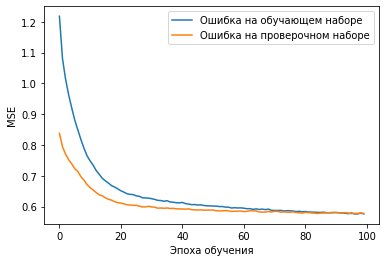

Средняя ошибка:  579.0
Средняя цена:  4077.0
Процент ошибки: 14.0%


In [ ]:
#Создаём сеть
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(x_my_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))
model.compile(optimizer=Adam(lr=0.0001), loss='mae')

#40000 примеров отводим обучающей выборке
n_val = 40000
history = model.fit(x_my_train[:n_val], 
                    y_my_train_scaled[:n_val],
                    batch_size=150,
                    epochs=100, 
                    validation_data=(x_my_train[n_val:], y_my_train_scaled[n_val:]), 
                    verbose=1)

import numpy as np

#Отобразим результаты
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_my_train[n_val:])
predict = y_train_scaler.inverse_transform(predict).flatten()

#Считаем среднюю цену, среднюю ошибку и средний процент ошибки
delta = predict - y_my_train[n_val:]
abs_delta = abs(delta)
mean_delta = np.sum(abs_delta)/len(abs_delta)
mean_price = np.sum(y_my_train[n_val:])/len(y_my_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

In [ ]:
print("Процент ошибки на проверочной выборке: ", round(100*mean_delta / mean_price), "%", sep="")

Процент ошибки на проверочной выборке: 14.0%


In [ ]:
#Предсказываем тестовую выборку
predict = model.predict(x_test)
predict = y_test_scaler.inverse_transform(predict).flatten()

sum = 0

for i in range(y_test.shape[0]):
  price = predict[i] 
  real_price = y_test[i] 
  sum += abs(((price / real_price) - 1) * 100)

result = sum/y_test.shape[0]  
print('Суммарный процент ошибки на тестовой выборке: ', round(result,2), "%", sep="")  

Суммарный процент ошибки на тестовой выборке: 14.99%


**Итоги:**

После чистки и обработки базы, преобразования её в данные которые можно подать на обучение сети, написания самой нейронной сети для обработки этих данных и её обучения и тестирования, получился следующий результат:

Процент ошибки на проверочной выборке: **14%**

Процент ошибки на тестовой выборке: **14.99%**

Процент ошибки как на проверочной, так и на тестовой выборке небольшой а значит результат работы нейронной сети можно считать хорошим А данный подход хорошим для решения подобных задач. 

Также после ряда экспериментов, можно точно сказать что первоначальная предобработка базы перед тем как её отправить на обучение в сеть играет огромную роль. Так как несбалансированность данных может привести к самым неприятным последствиям, в том числе "заучиванию" значений (если каких-то конкретных машин будет много - то сеть выучит их стоимость и будем всем остальным прогнозировать именно ее, что и происходило с изначальной базой, до того как я привела её в надлежащий вид).